In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Загружаем данные, если хотим что-то обновить

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
print(df.shape)
print(df_test.shape)

(3159633, 2)
(2784634, 2)


In [3]:
# Дропаем дубликаты в трейне

df.drop_duplicates(inplace=True, ignore_index=True)
print(df.shape)

(2741628, 2)


In [4]:
# Дропаем слишком короткие предложения

df.drop(df[df['sentence'].str.len() <= 5].index, inplace=True)

Распределения языков

In [12]:
df.head(16)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [13]:
df.describe()

,sentence,language
count,2738485,2738485
unique,2735693,59
top,Josh .,en
freq,15,130390


In [14]:
lang_count = (
    df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,en,130390
1,ar,108542
2,he,106893
3,ru,105198
4,ko,103888


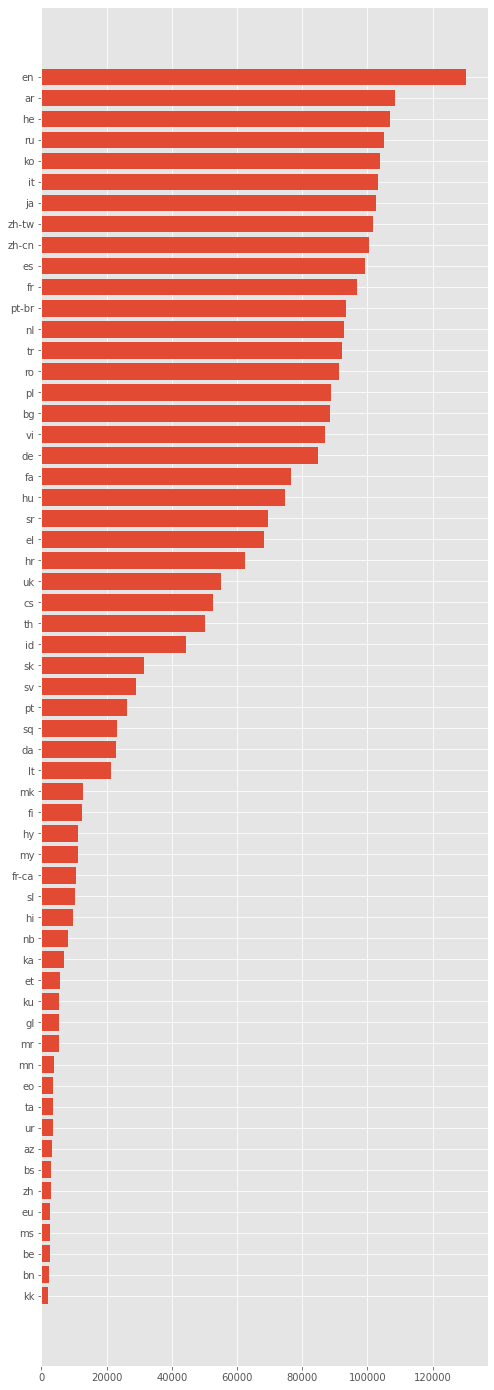

In [15]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [16]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
0,en,130390
58,kk,2012


Обучение

In [7]:
x = df['sentence']
y = df['language']


In [5]:
def preprocessor(sentence):
  allowed_chars = {'`', ' '}
  return ''.join([c for c in sentence if c.isalpha or c in allowed_chars])



CountVectorizer дал скор выше TF-IDF, поэтому используем его с биграммами и min_df=30, чтобы удалить редкие сочетания

In [9]:
%%time

vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1, 2), preprocessor=preprocessor, max_df=0.8, min_df=30)
x_vectorized = vectorizer.fit_transform(x)

CPU times: user 5min 54s, sys: 9.5 s, total: 6min 3s
Wall time: 6min 4s


In [10]:
# Save model

from joblib import dump, load

dump(vectorizer, 'vectorizer.joblib')


['vectorizer.joblib']

In [6]:
# load model

from joblib import dump, load

vectorizer = load('vectorizer.joblib')


In [8]:
x_vectorized.shape

(2738485, 69158)

In [8]:
import numpy as np

encoder = LabelEncoder()
y = encoder.fit_transform(y)


In [12]:
SEED = 42

x_train, x_test, y_train, y_test = train_test_split(x_vectorized, y, test_size=0.33, random_state=SEED)

In [13]:
from sklearn.utils.class_weight import compute_class_weight


classes = np.unique(y)
computed_weights = compute_class_weight('balanced', classes, y)
class_weight = {classes[i]: computed_weights[i] for i in range(classes.shape[0])}

In [14]:
# Save model

from joblib import dump, load

dump(x_vectorized, 'x_vec.joblib')
dump(y, 'y.joblib')

['y.joblib']

In [9]:
# load model

from joblib import dump, load

x_vectorized = load('x_vec.joblib')
y = load('y.joblib')

Тренировка основной модели

In [15]:
%%time
from sklearn.linear_model import SGDClassifier
import math
from tqdm import tqdm_notebook

classes = np.unique(y)
model = SGDClassifier(class_weight=class_weight, loss='log',
                      random_state=SEED)
# model.fit(x_train, y_train)
BATCH_SIZE = 20000
n_batches = math.ceil(x_train.shape[0] / BATCH_SIZE)
for i in tqdm_notebook(range(n_batches)):
  start = i * BATCH_SIZE
  end = min(BATCH_SIZE + start, x_train.shape[0])
  model.partial_fit(x_train[start:end], y_train[start:end], classes=classes)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



CPU times: user 2min 14s, sys: 1min 32s, total: 3min 47s
Wall time: 1min 58s


In [16]:
predictions_train = model.predict(x_train)
print(balanced_accuracy_score(y_train, predictions_train))

predictions = model.predict(x_test)
print(balanced_accuracy_score(y_test, predictions))

print(classification_report(y_test, predictions, target_names=encoder.classes_))

0.9027114243704364
0.8983141246942987
              precision    recall  f1-score   support

          ar       1.00      1.00      1.00     35862
          az       0.97      0.94      0.96      1128
          be       0.95      0.96      0.95       814
          bg       0.97      0.97      0.97     29097
          bn       0.98      1.00      0.99       779
          bs       0.03      0.44      0.06       994
          cs       0.99      0.95      0.97     17403
          da       0.95      0.60      0.73      7717
          de       0.98      0.98      0.98     28000
          el       1.00      1.00      1.00     22391
          en       0.99      0.98      0.99     42991
          eo       0.61      0.96      0.75      1151
          es       0.93      0.97      0.95     32861
          et       0.85      0.97      0.90      1975
          eu       0.89      0.97      0.93       901
          fa       1.00      1.00      1.00     25282
          fi       0.97      0.98      0.97

In [ ]:
# Save model

from joblib import dump, load

dump(model, 'clf.joblib')

In [9]:
# Restore model
from joblib import dump, load

model = load('clf.joblib')

In [17]:
encoder.transform(['ms'])

array([36])

In [18]:
pd.Series(encoder.inverse_transform(predictions[y_test == 36])).value_counts()

id       740
ms       139
nb        23
tr         4
sv         3
sr         3
lt         2
es         2
fr-ca      1
de         1
it         1
pl         1
fi         1
en         1
dtype: int64

Теперь создаем вспомогательные модели для тренировки на языках из одних семейств, которые имеют плохой скор

Для обучения этих моделей было принято решение заиспользовать дополнительный собранный датасет из исследования по DSL, которое проводилось как раз по этим языкам. Выделим 3 нужные нам семьи:

хорватско-сербско-боснийская

португальская

малазийско-индонезийская

In [ ]:
df_train_dsl = pd.read_csv('DSL-TRAIN.txt', sep='\t', names=['sentence', 'language'])
df_train_dsl.head()

In [ ]:
y_dsl = df_train_dsl['language']
y_dsl[y_dsl == 'pt-PT'] = 'pt'
y_dsl[y_dsl == 'pt-BR'] = 'pt-br'
y_dsl[y_dsl == 'my'] = 'ms'
df_train_dsl['language'] = y_dsl

Первой будет сербско-хорватско-боснийская семья

In [99]:
hr_df = df_train_dsl[(df_train_dsl['language'] == 'sr') | (df_train_dsl['language'] == 'hr') | (df_train_dsl['language'] == 'bs')]

In [100]:
x_hr = hr_df['sentence']
y_hr = hr_df['language']

In [101]:
vectorizer_hr = CountVectorizer(analyzer='char_wb', ngram_range=(1, 4), preprocessor=preprocessor, max_df=0.8, min_df=3)
x_hr_vect = vectorizer_hr.fit_transform(x_hr)

In [102]:
encoder_hr = LabelEncoder()
y_hr = encoder_hr.fit_transform(y_hr)


In [103]:
SEED = 42

x_train_hr, x_test_hr, y_train_hr, y_test_hr = train_test_split(x_hr_vect, y_hr, test_size=0.33, random_state=SEED)

In [114]:
from sklearn.linear_model import LogisticRegression

model_hr = LogisticRegression(class_weight='balanced', max_iter=1000, C=50)
model_hr.fit(x_train_hr, y_train_hr)
hr_pred = model_hr.predict(x_test_hr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [118]:
print(balanced_accuracy_score(y_test_hr, hr_pred))
print(classification_report(y_test_hr, hr_pred, target_names=encoder_hr.classes_))

0.8005076568881918
              precision    recall  f1-score   support

          bs       0.73      0.72      0.73      5871
          hr       0.81      0.80      0.81      5864
          sr       0.86      0.87      0.87      5798

    accuracy                           0.80     17533
   macro avg       0.80      0.80      0.80     17533
weighted avg       0.80      0.80      0.80     17533



Затем португальский и (возможно) галисийский

In [106]:
pt_df = df_train_dsl[(df_train_dsl['language'] == 'pt') | (df_train_dsl['language'] == 'pt-br')]
#| (df['language'] == 'gl')

In [107]:
x_pt = pt_df['sentence']
y_pt = pt_df['language']

In [108]:
vectorizer_pt = CountVectorizer(analyzer='char_wb', ngram_range=(1, 3), preprocessor=preprocessor, max_df=0.8, min_df=5)
x_pt_vect = vectorizer_pt.fit_transform(x_pt)

In [109]:
encoder_pt = LabelEncoder()
y_pt = encoder_pt.fit_transform(y_pt)


In [110]:
SEED = 42

x_train_pt, x_test_pt, y_train_pt, y_test_pt = train_test_split(x_pt_vect, y_pt, test_size=0.33, random_state=SEED)

In [113]:
from sklearn.linear_model import LogisticRegression


model_pt = LogisticRegression(class_weight='balanced', max_iter=1000, C=30)
model_pt.fit(x_train_pt, y_train_pt)
pt_pred = model_pt.predict(x_test_pt)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [117]:
print(balanced_accuracy_score(y_test_pt, pt_pred))
print(classification_report(y_test_pt, pt_pred, target_names=encoder_pt.classes_))

0.860919722860183
              precision    recall  f1-score   support

          pt       0.86      0.86      0.86      5922
       pt-br       0.86      0.86      0.86      5892

    accuracy                           0.86     11814
   macro avg       0.86      0.86      0.86     11814
weighted avg       0.86      0.86      0.86     11814



Алгоритм под малазийское семейство

In [64]:
pt_ms = df_train_dsl[(df_train_dsl['language'] == 'id') | (df_train_dsl['language'] == 'ms')]

In [65]:
x_ms = pt_ms['sentence']
y_ms = pt_ms['language']

In [66]:
vectorizer_ms = CountVectorizer(analyzer='char_wb', ngram_range=(1, 3), preprocessor=preprocessor, max_df=0.8, min_df=5)
x_ms_vect = vectorizer_ms.fit_transform(x_ms)

In [67]:
encoder_ms = LabelEncoder()
y_ms = encoder_ms.fit_transform(y_ms)

In [68]:
SEED = 42

x_train_ms, x_test_ms, y_train_ms, y_test_ms = train_test_split(x_ms_vect, y_ms, test_size=0.33, random_state=SEED)

In [115]:
from sklearn.linear_model import LogisticRegression


model_ms = LogisticRegression(class_weight='balanced', max_iter=1000, C=50)
model_ms.fit(x_train_ms, y_train_ms)
ms_pred = model_ms.predict(x_test_ms)

In [116]:
print(balanced_accuracy_score(y_test_ms, ms_pred))
print(classification_report(y_test_ms, ms_pred, target_names=encoder_ms.classes_))

0.9394954927810898
              precision    recall  f1-score   support

          id       0.95      0.94      0.95      5823
          ms       0.93      0.94      0.93      4480

    accuracy                           0.94     10303
   macro avg       0.94      0.94      0.94     10303
weighted avg       0.94      0.94      0.94     10303



In [ ]:
# bs (sr, hr конфликт)
# gl - галисийский (pt, pt-br конфликт)
# ms
# nb (норвежский скорее всего)



Окончательный предикт

In [10]:
x_test_vectorized = vectorizer.transform(df_test['sentence'])

In [129]:
test_pred = model.predict(x_test_vectorized)
test_pred_decoded = encoder.inverse_transform(test_pred)

In [130]:
df_test['language'] = test_pred_decoded

In [132]:
df_test_pt = df_test[(df_test['language'] == 'pt') | (df_test['language'] == 'pt-br')]

In [133]:
df_test_hr = df_test[(df_test['language'] == 'sr') | (df_test['language'] == 'hr') | (df_test['language'] == 'bs')]

In [134]:
df_test_ms = df_test[(df_test['language'] == 'ms') | (df_test['language'] == 'id')]

In [142]:
df_test_lang = df_test['language']

In [143]:
df_test_pt_vec = vectorizer_pt.transform(df_test_pt['sentence'])
df_test_lang[(df_test_lang == 'pt') | (df_test_lang == 'pt-br')] = encoder_pt.inverse_transform(model_pt.predict(df_test_pt_vec))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
df_test_hr_vec = vectorizer_hr.transform(df_test_hr['sentence'])
df_test_lang[(df_test_lang == 'sr') | (df_test_lang == 'hr') | (df_test_lang == 'bs')] = encoder_hr.inverse_transform(model_hr.predict(df_test_hr_vec))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [145]:
df_test_ms_vec = vectorizer_ms.transform(df_test_ms['sentence'])
df_test_lang[(df_test_lang == 'ms') | (df_test_lang == 'id')] = encoder_ms.inverse_transform(model_ms.predict(df_test_ms_vec))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [146]:
df_test['language'] = df_test_lang

In [149]:
df_test[['index', 'language']].to_csv('out1.csv', index=False)
